In [48]:
import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
import matplotlib.pyplot as plt
from trimesh.exchange.obj import load_obj
from trimesh.transformations import decompose_matrix, translation_from_matrix, euler_from_matrix, compose_matrix
file = '../test_data/rotated.png'
obj = load_obj(open('../gmfx/data/mediapipe_template.obj'))

In [49]:
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5) as face_mesh:
    
    image = cv2.imread(file)
    # Convert the BGR image to RGB before processing.
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image)

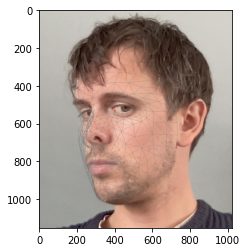

In [50]:
annotated_image = image.copy()
face_landmarks = results.multi_face_landmarks[0]
mp_drawing.draw_landmarks(
    image=annotated_image,
    landmark_list=face_landmarks,
    connections=mp_face_mesh.FACEMESH_TESSELATION,
    landmark_drawing_spec=None,
    connection_drawing_spec=mp_drawing_styles
    .get_default_face_mesh_tesselation_style())

plt.imshow(annotated_image)

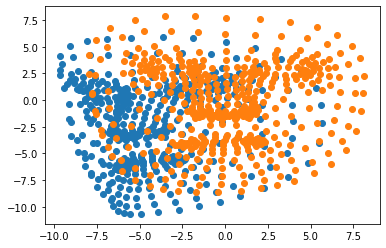

In [115]:
recon = np.load('../mp.npz')
v_, f = recon['v'], recon['f']
mat = recon['mat']
img = recon['img']

plt.scatter(v_[:, 0], v_[:, 1])
v = np.c_[v_, np.ones(468)] @ np.linalg.inv(mat).T
v = v[:, :3]
plt.scatter(v[:, 0], v[:, 1])

In [119]:
20 + v[:, 2].mean() 

24.13551427762946

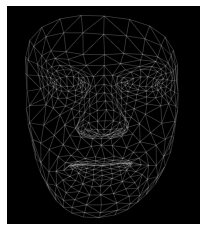

In [117]:
import os
os.environ['DISPLAY'] = ':0.0'  # need for deepnet

import trimesh
import numpy as np
import matplotlib.pyplot as plt
from pyrender import Scene, Mesh, OffscreenRenderer
from pyrender import Node, DirectionalLight, IntrinsicsCamera
from pyrender.constants import RenderFlags
# Create pyrender-compatible mesh
mesh = trimesh.Trimesh(v, f)
mesh_pr = Mesh.from_trimesh(mesh, smooth=True, wireframe=True)

# Create scene and add head
scene = Scene(bg_color=[0, 0, 0, 0], ambient_light=(255, 255, 255))
head = Node(mesh=mesh_pr)
scene.add_node(head)

camera = IntrinsicsCamera(fx=img.shape[1], fy=img.shape[1], cx=img.shape[1]//2, cy=img.shape[0]//2,
                          )
#print(camera.get_projection_matrix(457, 451))
#camera= PerspectiveCamera(yfov=np.pi / 2)
scene.add_node(Node(camera=camera, translation=(0, 0, 20)))

# Create spotlight, directly in front of head (so need to translate)
# Also zoom out in z-direction
light = DirectionalLight(intensity=10)
scene.add_node(Node(light=light))

# Create renderer with viewport of the same size as original image
r = OffscreenRenderer(viewport_width=img.shape[1], viewport_height=img.shape[0])
color, depth = r.render(scene, flags=RenderFlags.RGBA | RenderFlags.ALL_WIREFRAME)
r.delete()
color = color.copy()

# Plot original (cropped) image and reconstructed head
# plt.figure(figsize=(5,5))
alpha = color[:, :, 3, None] / 255.
alpha[alpha > 0.] = 1
#color = color[:, :, :3] * alpha + (1 - alpha) * img
color = color[:, :, :3]
#color[color == 0] = img[color == 0]
plt.imshow(color.astype(np.uint8))
plt.axis('off')
plt.show()


In [ ]:
import os
os.environ['DISPLAY'] = ':0.0'  # need for deepnet

import trimesh
import numpy as np
import matplotlib.pyplot as plt
from pyrender import Scene, Mesh, OffscreenRenderer
from pyrender import Node, PerspectiveCamera, DirectionalLight, IntrinsicsCamera

# Create pyrender-compatible mesh
mesh = trimesh.Trimesh(v, f)
mesh_pr = Mesh.from_trimesh(mesh)

# Create scene and add head
scene = Scene(bg_color=[0, 0, 0], ambient_light=(255, 255, 255))
head = Node(mesh=mesh_pr)
scene.add_node(head)

camera = IntrinsicsCamera(fx=457, fy=451, cx=456//2, cy=451//2, znear=1, zfar=10000)#PerspectiveCamera(yfov=np.pi / 2)
scene.add_node(Node(camera=camera, translation=(0, 0, 0)))

# Create spotlight, directly in front of head (so need to translate)
# Also zoom out in z-direction
light = DirectionalLight(intensity=10)
scene.add_node(Node(light=light))

# Create renderer with viewport of the same size as original image
r = OffscreenRenderer(viewport_width=457, viewport_height=451)
color, depth = r.render(scene)
r.delete()

# Plot original (cropped) image and reconstructed head
plt.figure(figsize=(5,5))
plt.imshow()
plt.imshow(color)
plt.axis('off')
plt.show()

In [ ]:
background = image.copy()
vidx = [389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400, 377,  # contour
        152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162,
        94, 19, 1, 4, 5, 195, 197, 6]
#vidx = range(468, 478)
vidx = np.unique(list(mp_face_mesh.FACEMESH_FACE_OVAL))
for i in vidx:
    lm = results.multi_face_landmarks[0].landmark[i]
    x = int(lm.x * image.shape[0])
    y = int(lm.y * image.shape[0])

    cv2.circle(background, center=(x, y), radius=1, thickness=2, color=(255, 0, 0))
    
plt.imshow(background)